In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
sns.set()

# Read in data
## Train data

In [3]:
train_demo = pd.read_csv('../data/traindemographics.csv')
train_prevloan = pd.read_csv('../data/trainprevloans.csv')
train_perf = pd.read_csv('../data/trainperf.csv')

## Test data


In [4]:
test_demo = pd.read_csv('../data/testdemographics.csv')
test_prevloan = pd.read_csv('../data/testprevloans.csv')
test_perf = pd.read_csv('../data/testperf.csv')

# Initial Inspection

In [5]:
print(train_demo.info())
train_demo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
customerid                    4346 non-null object
birthdate                     4346 non-null object
bank_account_type             4346 non-null object
longitude_gps                 4346 non-null float64
latitude_gps                  4346 non-null float64
bank_name_clients             4346 non-null object
bank_branch_clients           51 non-null object
employment_status_clients     3698 non-null object
level_of_education_clients    587 non-null object
dtypes: float64(2), object(7)
memory usage: 305.7+ KB
None


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


Demographic information

- Get age from birth date
- Categories for Bank account type
- Categories for employment status
- Categories for education level

In [6]:
train_demo.birthdate.isna().sum()

0

In [7]:
print(train_demo.level_of_education_clients.value_counts())
print(train_demo.level_of_education_clients.isna().sum())

Graduate         420
Secondary         89
Post-Graduate     68
Primary           10
Name: level_of_education_clients, dtype: int64
3759


Level of education is generally unknown so may not be worth including in the model

In [8]:
print(train_demo.employment_status_clients.value_counts())
print(train_demo.employment_status_clients.isna().sum())

train_demo['employment_status_clients'].replace(np.nan, "Unknown", inplace = True)
test_demo['employment_status_clients'].replace(np.nan, "Unknown", inplace = True)

print(train_demo.employment_status_clients.value_counts())
print(train_demo.employment_status_clients.isna().sum())

Permanent        3146
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: employment_status_clients, dtype: int64
648
Permanent        3146
Unknown           648
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: employment_status_clients, dtype: int64
0


In [9]:
print(train_demo.bank_account_type.value_counts())
print(train_demo.bank_account_type.isna().sum())

Savings    3425
Other       865
Current      56
Name: bank_account_type, dtype: int64
0


In [10]:
def demo_features(train_demo):
    train_demo_cols = train_demo[['customerid']].copy(deep = True)
    train_demo_cols['age'] =  date.today().year - pd.DatetimeIndex(train_demo['birthdate']).year
    train_demo_cols = pd.concat([train_demo_cols, pd.get_dummies(train_demo['bank_account_type'], 'bank_account_type')], axis=1)
    train_demo_cols = pd.concat([train_demo_cols, pd.get_dummies(train_demo['employment_status_clients'], 'employment_status_clients')], axis=1)

    return train_demo_cols

train_demo_cols = demo_features(train_demo)

In [11]:
print(train_prevloan.info())
train_prevloan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
customerid         18183 non-null object
systemloanid       18183 non-null int64
loannumber         18183 non-null int64
approveddate       18183 non-null object
creationdate       18183 non-null object
loanamount         18183 non-null float64
totaldue           18183 non-null float64
termdays           18183 non-null int64
closeddate         18183 non-null object
referredby         1026 non-null object
firstduedate       18183 non-null object
firstrepaiddate    18183 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB
None


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [12]:
train_prevloan.isin([np.nan]).sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

Previous loan behviour

- Mean loan amount
- Number of loans taken


- Times first payment past first due date
- Times closed date after approveddate + termdays


- Days between last loan and this one
- Last loan on time
- Last loan value

In [13]:
def prevloan_features(train_prevloan):
    train_prevloan_cols = train_prevloan.copy(deep = True)

    train_prevloan_cols['firstrepaiddate'] = pd.to_datetime(train_prevloan_cols['firstrepaiddate']) 
    train_prevloan_cols['firstduedate'] = pd.to_datetime(train_prevloan_cols['firstduedate'])
    train_prevloan_cols['missed_first_due_date'] = train_prevloan_cols['firstrepaiddate'].dt.date > train_prevloan_cols['firstduedate'].dt.date

    train_prevloan_cols['closeddate'] = pd.to_datetime(train_prevloan_cols['closeddate'])
    train_prevloan_cols['approveddate'] = pd.to_datetime(train_prevloan_cols['approveddate'])
    train_prevloan_cols['termdays_td'] = pd.to_timedelta(train_prevloan_cols['termdays'], unit= 'days')
    train_prevloan_cols['finalduedate'] = train_prevloan_cols['approveddate'] + train_prevloan_cols['termdays_td']
    train_prevloan_cols['closed_loan_late'] = train_prevloan_cols['closeddate'].dt.date > train_prevloan_cols['finalduedate'].dt.date

    train_prevloan_cols_grp = train_prevloan_cols[['customerid','loanamount', 'missed_first_due_date', 'closed_loan_late', 'termdays']]

    train_prevloan_cols_grp_cols = train_prevloan_cols_grp.groupby('customerid', as_index = False).agg({'loanamount':'mean', 'missed_first_due_date': 'sum', 'closed_loan_late':'sum', 'termdays':'mean'})
    train_prevloan_cols_grp_cols.rename( columns = {'loanamount': 'avg_loanamount', 'missed_first_due_date': 'total_missed_first_due_date', 'closed_loan_late':'total_closed_loan_late', 'termdays':'average_termdays'}   , inplace = True)

    return train_prevloan_cols_grp_cols

train_prevloan_cols_grp_cols = prevloan_features(train_prevloan)
train_prevloan_cols_grp_cols

,customerid,avg_loanamount,total_missed_first_due_date,total_closed_loan_late,average_termdays
0,8a1088a0484472eb01484669e3ce4e0b,10000.000000,1.0,1.0,15.000000
1,8a1a1e7e4f707f8b014f797718316cad,17500.000000,1.0,1.0,37.500000
2,8a1a32fc49b632520149c3b8fdf85139,12857.142857,1.0,1.0,19.285714
3,8a1eb5ba49a682300149c3c068b806c7,16250.000000,1.0,0.0,33.750000
4,8a1edbf14734127f0147356fdb1b1eb2,10000.000000,0.0,0.0,22.500000
...,...,...,...,...,...
4354,8a858fff5a28d297015a33bc2e845305,16666.666667,0.0,0.0,35.000000
4355,8a858fff5a36fe68015a37f8550a02a2,15000.000000,0.0,1.0,27.500000
4356,8a858fff5a36fe68015a3ac5851618ab,10000.000000,0.0,0.0,30.000000
4357,8a858fff5a36fe68015a3b8dcb8a3843,13333.333333,0.0,0.0,22.500000


In [14]:
print(train_perf.info())
train_perf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
customerid       4368 non-null object
systemloanid     4368 non-null int64
loannumber       4368 non-null int64
approveddate     4368 non-null object
creationdate     4368 non-null object
loanamount       4368 non-null float64
totaldue         4368 non-null float64
termdays         4368 non-null int64
referredby       587 non-null object
good_bad_flag    4368 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB
None


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [15]:
train_perf.isin([np.nan]).sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [16]:
train_perf['good_bad_ind'] = np.where(train_perf['good_bad_flag']=="Good", 1, 0)
train_perf['good_bad_ind'].value_counts()

1    3416
0     952
Name: good_bad_ind, dtype: int64

Most people do not default on their loans

Perf columns:

- Total amount due 
- Loan number
- Term days

In [17]:
def perf_features(train_perf, train = True):
    if train:
        train_perf['good_bad_ind'] = np.where(train_perf['good_bad_flag']=="Good", 1, 0)
        train_perf_cols = train_perf[['customerid', 'loannumber', 'loanamount', 'termdays', 'good_bad_ind']]
    else:
        train_perf_cols = train_perf[['customerid', 'loannumber', 'loanamount', 'termdays']]
    return train_perf_cols


train_perf_cols = perf_features(train_perf, train = True)

# Make training dataset

Some data will be lost due to the mismach in the number of rows in each of the tables, this should be investigated when time allows.

In [18]:
def merge_sets(train_perf_cols, train_demo_cols, train_prevloan_cols_grp_cols):
    
    train = pd.merge(train_perf_cols, train_demo_cols, how ='inner', left_on='customerid', right_on='customerid')
    train = pd.merge(train, train_prevloan_cols_grp_cols, how ='inner', left_on='customerid', right_on='customerid')
    return train

train = merge_sets(train_perf_cols, train_demo_cols, train_prevloan_cols_grp_cols)
train

,customerid,loannumber,loanamount,termdays,good_bad_ind,age,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,employment_status_clients_Unknown,avg_loanamount,total_missed_first_due_date,total_closed_loan_late,average_termdays
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,30,1,48,0,1,0,0,1,0,0,0,0,0,18181.818182,3.0,4.0,30.0
1,8a8588f35438fe12015444567666018e,7,20000.0,15,1,36,0,1,0,0,1,0,0,0,0,0,10000.000000,1.0,1.0,17.5
2,8a85890754145ace015429211b513e16,3,10000.0,15,1,43,0,0,1,0,1,0,0,0,0,0,10000.000000,2.0,2.0,22.5
3,8a858970548359cc0154883481981866,9,40000.0,30,1,34,0,1,0,0,1,0,0,0,0,0,18750.000000,0.0,0.0,37.5
4,8a858e095c59b91b015c5e5cea3719bc,3,10000.0,30,1,31,0,0,1,0,1,0,0,0,0,0,10000.000000,0.0,0.0,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858e395cb1d4d9015cb2115b1d13d7,2,10000.0,15,0,41,0,0,1,0,0,0,0,0,0,1,10000.000000,0.0,1.0,15.0
3268,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.0,30,0,31,0,0,1,0,1,0,0,0,0,0,10000.000000,0.0,0.0,30.0
3269,8a858f365b2547f3015b284597147c94,3,10000.0,15,0,31,0,0,1,0,1,0,0,0,0,0,10000.000000,1.0,1.0,15.0
3270,8a858f935ca09667015ca0ee3bc63f51,2,10000.0,30,0,30,0,0,1,0,1,0,0,0,0,0,10000.000000,0.0,0.0,30.0


In [19]:
train.isin([np.nan]).sum()

customerid                                 0
loannumber                                 0
loanamount                                 0
termdays                                   0
good_bad_ind                               0
age                                        0
bank_account_type_Current                  0
bank_account_type_Other                    0
bank_account_type_Savings                  0
employment_status_clients_Contract         0
employment_status_clients_Permanent        0
employment_status_clients_Retired          0
employment_status_clients_Self-Employed    0
employment_status_clients_Student          0
employment_status_clients_Unemployed       0
employment_status_clients_Unknown          0
avg_loanamount                             0
total_missed_first_due_date                0
total_closed_loan_late                     0
average_termdays                           0
dtype: int64

In [20]:
train.columns

Index(['customerid', 'loannumber', 'loanamount', 'termdays', 'good_bad_ind',
       'age', 'bank_account_type_Current', 'bank_account_type_Other',
       'bank_account_type_Savings', 'employment_status_clients_Contract',
       'employment_status_clients_Permanent',
       'employment_status_clients_Retired',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student',
       'employment_status_clients_Unemployed',
       'employment_status_clients_Unknown', 'avg_loanamount',
       'total_missed_first_due_date', 'total_closed_loan_late',
       'average_termdays'],
      dtype='object')

# Data analysis

In [21]:
data = train.copy(deep = True)

In [22]:
# How many of each account type are there

print(data[['bank_account_type_Current','bank_account_type_Other','bank_account_type_Savings']].sum())

# What percent in each category default
curr = data[data['bank_account_type_Current']==1]
print('Current that default: ', 1-curr['good_bad_ind'].mean())

other = data[data['bank_account_type_Other']==1]
print('Other that default: ', 1-other['good_bad_ind'].mean())

savings = data[data['bank_account_type_Savings']==1]
print('Savings that default: ', 1-savings['good_bad_ind'].mean())


bank_account_type_Current      46
bank_account_type_Other       653
bank_account_type_Savings    2573
dtype: int64
Current that default:  0.10869565217391308
Other that default:  0.13476263399693722
Savings that default:  0.2405752040419743


Loans are taken most often on customers with saving accounts.
Savings are the biggest group and they have the highest proportion of defaulted loans

In [23]:
# How many of each category type are there

print(data[['employment_status_clients_Contract',
            'employment_status_clients_Permanent',
            'employment_status_clients_Retired',
            'employment_status_clients_Self-Employed',
            'employment_status_clients_Student',
            'employment_status_clients_Unemployed']].sum())

# What percent in each category default
cont = data[data['employment_status_clients_Contract']==1]
print('Perm that default: ', 1-cont['good_bad_ind'].mean())

perm = data[data['employment_status_clients_Permanent']==1]
print('Perm that default: ', 1-perm['good_bad_ind'].mean())

ret = data[data['employment_status_clients_Retired']==1]
print('Retired that default: ', 1-ret['good_bad_ind'].mean())

self = data[data['employment_status_clients_Self-Employed']==1]
print('Self that default: ', 1-self['good_bad_ind'].mean())

stud = data[data['employment_status_clients_Student']==1]
print('Student that default: ', 1-stud['good_bad_ind'].mean())

unemp = data[data['employment_status_clients_Unemployed']==1]
print('Unemp that default: ', 1-unemp['good_bad_ind'].mean())

employment_status_clients_Contract            1
employment_status_clients_Permanent        2343
employment_status_clients_Retired             4
employment_status_clients_Self-Employed     277
employment_status_clients_Student           111
employment_status_clients_Unemployed         43
dtype: int64
Perm that default:  0.0
Perm that default:  0.20486555697823305
Retired that default:  0.0
Self that default:  0.16245487364620936
Student that default:  0.2702702702702703
Unemp that default:  0.16279069767441856


Most clients are permanent. Students default the most often, with permanent staff coming in next

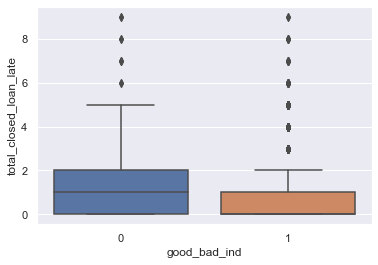

In [24]:
sns.boxplot(data = data, y='total_closed_loan_late', x ='good_bad_ind')

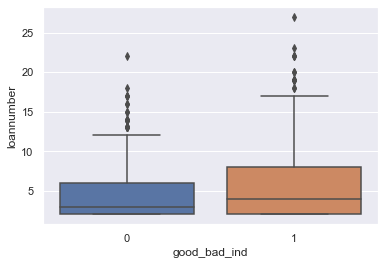

In [25]:
sns.boxplot(data = data, y='loannumber', x ='good_bad_ind')

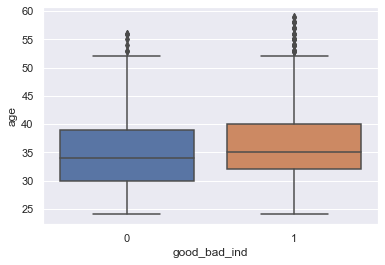

In [26]:
sns.boxplot(data = data, y='age', x ='good_bad_ind')

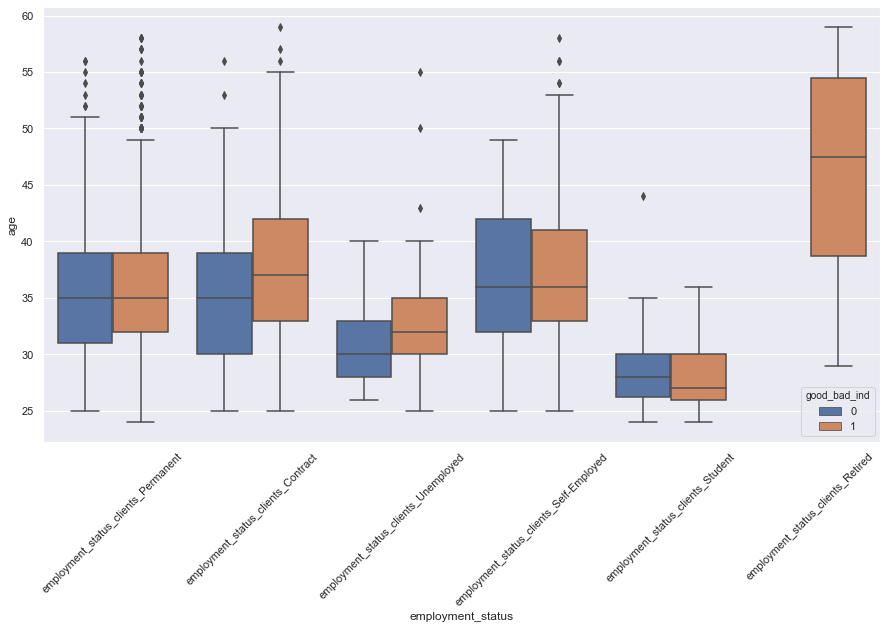

In [27]:
data["employment_status"] = data[['employment_status_clients_Contract',
            'employment_status_clients_Permanent',
            'employment_status_clients_Retired',
            'employment_status_clients_Self-Employed',
            'employment_status_clients_Student',
            'employment_status_clients_Unemployed']].idxmax(axis=1)



fig, axs = plt.subplots(1,1,figsize=(15,8))
axs.set_xticklabels(['employment_status_clients_Contract',
            'employment_status_clients_Permanent',
            'employment_status_clients_Retired',
            'employment_status_clients_Self-Employed',
            'employment_status_clients_Student',
            'employment_status_clients_Unemployed'], rotation=45)
sns.boxplot(data = data, y='age', x ='employment_status', hue = 'good_bad_ind')

[Text(0, 0, 'employment_status_clients_Contract'),
 Text(0, 0, 'employment_status_clients_Permanent'),
 Text(0, 0, 'employment_status_clients_Retired'),
 Text(0, 0, 'employment_status_clients_Self-Employed'),
 Text(0, 0, 'employment_status_clients_Student'),
 Text(0, 0, 'employment_status_clients_Unemployed')]

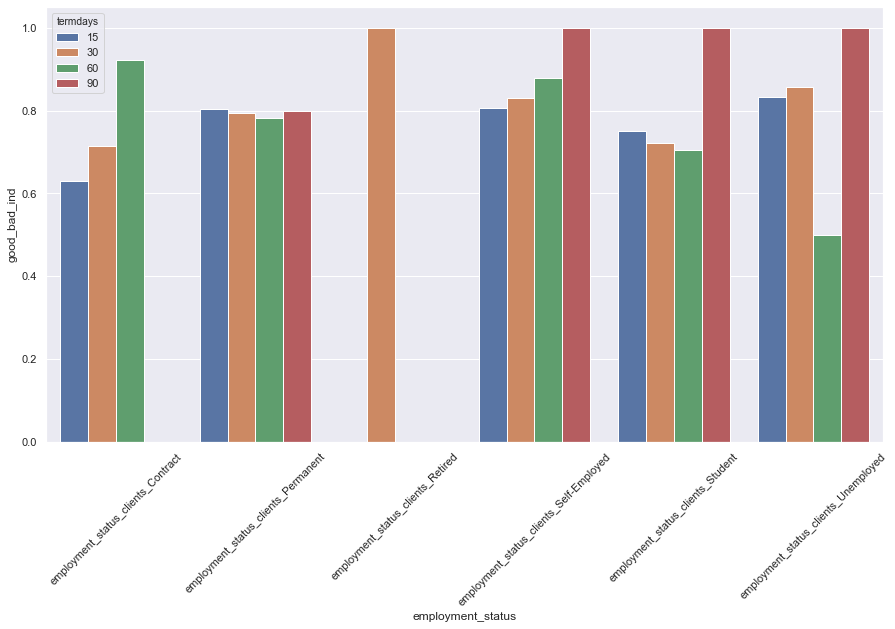

In [29]:
fig, axs = plt.subplots(1,1,figsize=(15,8))
gb = data[['termdays', 'employment_status', 'good_bad_ind']].groupby(['employment_status', 'termdays']).mean().reset_index()
sns.barplot(data = gb, x= 'employment_status', y = 'good_bad_ind',  hue = 'termdays')

axs.set_xticklabels(['employment_status_clients_Contract',
            'employment_status_clients_Permanent',
            'employment_status_clients_Retired',
            'employment_status_clients_Self-Employed',
            'employment_status_clients_Student',
            'employment_status_clients_Unemployed'], rotation=45)

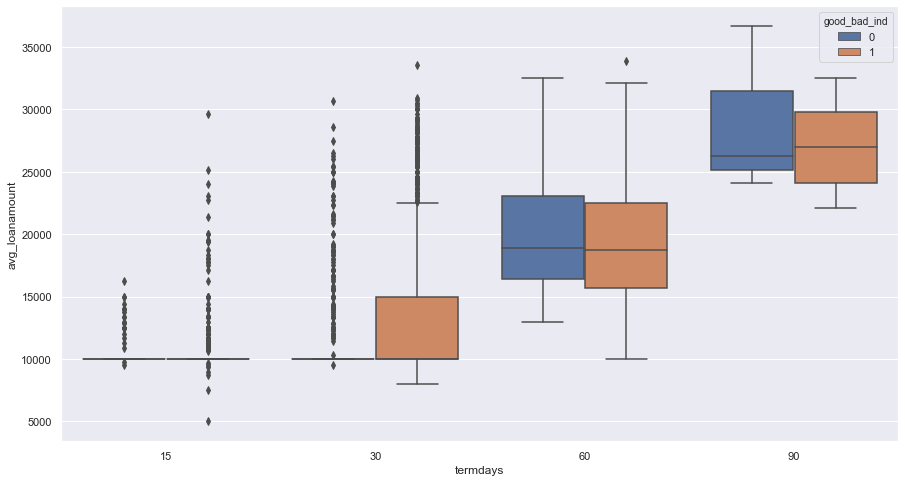

In [30]:
fig, axs = plt.subplots(1,1,figsize=(15,8))
sns.boxplot(data = data, y='avg_loanamount', x ='termdays', hue = 'good_bad_ind')

In [31]:
data[["termdays", 'good_bad_ind']].groupby(['termdays']).mean()

,good_bad_ind
termdays,
15,0.767883
30,0.783980
60,0.803653
90,0.857143


Short term loans are more likely to be defaulted

# Make test dataset

In [32]:
test_demo_cols = demo_features(test_demo)
test_prevloan_cols_grp_cols = prevloan_features(test_prevloan)
test_perf_cols = perf_features(test_perf, False)

In [33]:
test = merge_sets(test_perf_cols, test_demo_cols, test_prevloan_cols_grp_cols)

In [34]:
test.columns

Index(['customerid', 'loannumber', 'loanamount', 'termdays', 'age',
       'bank_account_type_Current', 'bank_account_type_Other',
       'bank_account_type_Savings', 'employment_status_clients_Contract',
       'employment_status_clients_Permanent',
       'employment_status_clients_Retired',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student',
       'employment_status_clients_Unemployed',
       'employment_status_clients_Unknown', 'avg_loanamount',
       'total_missed_first_due_date', 'total_closed_loan_late',
       'average_termdays'],
      dtype='object')

# Baseline

In [35]:
n = train_perf.shape[0]
random_guess = np.random.randint(2, size=n)

In [36]:
sum(random_guess == train_perf['good_bad_ind'])/n

0.48878205128205127

Performamce to beat to have more value than a random guess ~50%

# Modelling
## Random Forest

In [37]:
features = train.drop(['customerid','good_bad_ind'] , axis=1)
y = train['good_bad_ind']
rf = RandomForestClassifier(n_estimators=100)
rf.fit(features, y)
y_pred = rf.predict(features)
accuracy_score(y, y_pred)

0.9428484107579462

Peformance when predicting on self ~ 94%

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7567237163814181

In [39]:
ind = rf.feature_importances_.argsort()[::-1]
features = rf.feature_importances_[ind]
cols = train.columns[ind]
for i in range(len(X_test.columns)):
    print(cols[i], features[i])

termdays 0.3298527366451739
total_missed_first_due_date 0.11488132236268224
customerid 0.11265519738738558
employment_status_clients_Unknown 0.09271317155094401
avg_loanamount 0.08507102445427668
employment_status_clients_Unemployed 0.08388581692193958
loannumber 0.04209329276376596
loanamount 0.040038265476920416
bank_account_type_Savings 0.020911632213758927
employment_status_clients_Student 0.01888857516126254
bank_account_type_Current 0.01613803953759286
age 0.014832529450217494
employment_status_clients_Retired 0.010520039114054145
employment_status_clients_Permanent 0.009305042478043526
employment_status_clients_Self-Employed 0.005436943794198318
good_bad_ind 0.0026748307110508315
employment_status_clients_Contract 0.00010153997673293588
bank_account_type_Other 0.0


### Test Output

In [40]:
test_pred = rf.predict(test.drop('customerid', axis =1))

In [41]:
test_output = test[['customerid']]
test_output['Good_Bad_flag'] = test_pred
test_output.rename({'customerid': 'customerID'}, inplace=True, axis =1)
test_output.to_csv('../output/predictions.csv')

/Users/donnestevenson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/donnestevenson/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


# Business Questions

1. What would be your recommendation to the client based on your analysis?
2. Please provide 1 relevant & interesting visualization and describe it to the client
3. If you were allowed to use external data what kind of data would you think of? How do you think it would impact your predictions?
4. What would have been your next steps if you had more time?
5. Do you have any comments / feedback about the assessment?

### Question 1.

The model is perfroming at abour 75% on a test set taken from the trainig data the moment. 
Based on the analysis, students are the most likely to default with a default proportion of about 27%. However the the group that do payback their loans are on average older than those that dont. Suggesting older students are less risky to offer loans to.

### Question 2.

This visulisation show the age and employment status of clients seperated by if they paid back their loans on time or not. The higher the bar the higher the percentage of the loans that group paid off in time. 
Notice that for the employment_status_clients_Contract group those that paid back the loan (orange bar) are on average older than those that did not (blue bar) this suggests that the younger clients who are contracted are more risky. Similarly the unemployed group who did not pay their loans were on average younger than those that did. Without assuming caustaion this does indicate a relationship between age and liklihood for paying back loans for specific emplyment groups. 
The unemplyed group have a particularly low percentages of successful repayaments on 60 day loans. 

This suggests further investgation into age and loan repayments is warranted. 

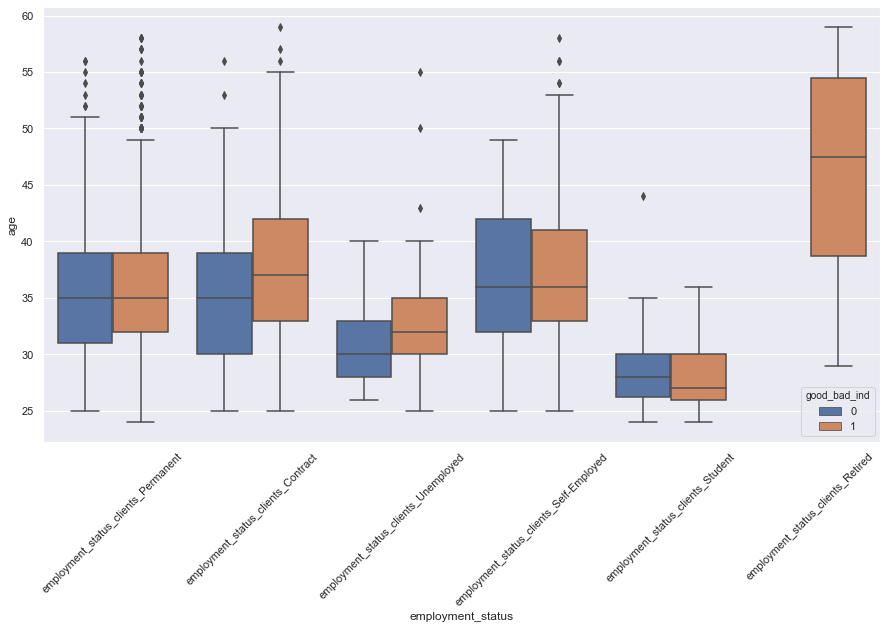

In [370]:
fig, axs = plt.subplots(1,1,figsize=(15,8))
axs.set_xticklabels(['employment_status_clients_Contract',
            'employment_status_clients_Permanent',
            'employment_status_clients_Retired',
            'employment_status_clients_Self-Employed',
            'employment_status_clients_Student',
            'employment_status_clients_Unemployed'], rotation=45)
sns.boxplot(data = data, y='age', x ='employment_status', hue = 'good_bad_ind')

### Question 3.

If external data could be used, the latitude and logintiude data could be added to investigate if there exists a relationship between location and risk. 


### Question 4.

1. Look at which group they make the most profit off of by comparing the amout total due, loan anmount and the groups least likely to default. 
2. More time invetigating hyperparameters and models that might give better performance.
3. Investigate the inner join on the merge of data sets that is resulting in data loss. 


### Question 5.

It would be nice to be able to work on this over a few days. In order to have some time to thing and plan.